# Text Comparison Metrics for Modification Detection

In this notebook, we will explore various metrics to detect and quantify text modifications. These algorithms, born out of the field of Natural Language Processing (NLP) and Machine Learning, can help us understand the degree of similarity or difference between two pieces of text.

Below are the metrics we will be covering:

1. **Edit Distance (Levenshtein Distance)**: This algorithm computes the minimum number of operations (insertions, deletions, substitutions) required to transform one string into another. 

2. **Cosine Similarity**: This measure calculates the cosine of the angle between two vectors representing the texts. A cosine value close to 1 implies high similarity. This is often used in combination with TF-IDF or word embeddings. Read more [here](https://en.wikipedia.org/wiki/Cosine_similarity).

3. **Jaccard Similarity**: Defined as the size of the intersection divided by the size of the union of the sample sets. It is commonly used to compare the similarity and diversity of sample sets. For more information, refer to [this link](https://en.wikipedia.org/wiki/Jaccard_index).

4. **BLEU (Bilingual Evaluation Understudy)**: Initially designed for evaluating machine translation, BLEU can be used for general text comparison. You can read the original [BLEU paper here](https://www.aclweb.org/anthology/P02-1040.pdf).

5. **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**: ROUGE is a set of metrics used for evaluating automatic summarization and machine translation. Read the [original paper](https://www.aclweb.org/anthology/W04-1013.pdf) for more insights.

6. **Word Mover's Distance (WMD)**: WMD uses word embeddings to calculate the "distance" between two documents. This is described in detail in the [original WMD paper](http://proceedings.mlr.press/v37/kusnerb15.pdf).

7. **Semantic Similarity Measures** using transformer models: Models such as BERT, RoBERTa, and others can be used to compute a semantic similarity score between two texts. The [BERT paper](https://arxiv.org/abs/1810.04805) is a good starting point for understanding these models.

Each of these metrics has its strengths and weaknesses, and the choice depends on the specific requirements of the task at hand. In the upcoming sections of this notebook, we will delve deeper into each of these methods, understand their implementation, and interpret their results. Let's get started!

In [1]:
!pip install sentence-transformers

!pip install tensorflow_hub

In [2]:
import pandas as pd
import string
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity

from nltk.translate.bleu_score import sentence_bleu

import time 

2023-06-09 21:50:28.921134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
text1 = "Aina eats potatoes in the garden"
text2 = "Aina likes potatoes"

## Text Cleaning 

In [4]:
def remove_punctuations(txt, punct = set(string.punctuation)):
    '''
    Removes punctuations from a given text.
    
    Parameters
    ----------
    txt : str
        The input text from which punctuations are to be removed.
    punct : set, optional
        The set of punctuation characters to be removed. Default is all punctuation characters.
    
    Returns
    -------
    str
        The input text with all specified punctuation characters removed.
    '''
    return ''.join([c for c in txt.lower() if c not in punct])

  
def remove_stopwords(txt, sw = set(stopwords.words('english'))):
    '''
    Removes stopwords from a given text.
    
    Parameters
    ----------
    txt : str
        The input text from which stopwords are to be removed.
    sw : set, optional
        The set of stopwords to be removed. Default is English stopwords from NLTK corpus.
    
    Returns
    -------
    str
        The input text with all specified stopwords removed.
    '''
    return ' '.join([w for w in txt.split() if w not in sw])


def clean_text(txt):
    '''
    Cleans a given text by removing specific line feed characters, punctuations and stopwords.
    
    Parameters
    ----------
    txt : str
        The input text to be cleaned.
    
    Returns
    -------
    str
        The cleaned text, with line feed characters, punctuations and stopwords removed and converted to lowercase.
    '''
    txt = txt.replace('\n', ' ').replace('\r', ' ').replace('\'', '')
    txt = remove_punctuations(txt)
    txt = remove_stopwords(txt)
    return txt

def cleaning_pipeline(txt):
    
    txt = remove_punctuations(txt)
    txt = remove_stopwords(txt)
    txt = clean_text(txt)
    return txt

## 1. Levensthein distance

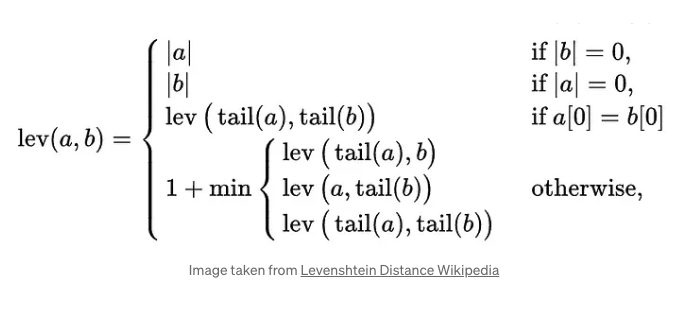

In [5]:
def direct_lev(a, b):
    """
    Calculates the Levenshtein distance between two strings.
    This is the minimum number of single-character edits (insertions, deletions, or substitutions)
    required to change string 'a' into string 'b'.
    
    Parameters
    ----------
    a : str
        The first string to compare.
    b : str
        The second string to compare.
    
    Returns
    -------
    int
        The Levenshtein distance between 'a' and 'b'.
    """
    
    if len(b) == 0:
        return len(a)
    elif len(a) == 0:
        return len(b)
    elif a[0] == b[0]:
        return lev(a[1:],b[1:])
    else:
        return 1 + min([lev(a[1:], b), lev(a, b[1:]), lev(a[1:], b[1:])])
    

def lev(a, b):
    """
    Calculates the Levenshtein distance between two strings.
    This is the minimum number of single-character edits (insertions, deletions, or substitutions)
    required to change string 'a' into string 'b'.
    
    Parameters
    ----------
    a : str
        The first string to compare.
    b : str
        The second string to compare.
    
    Returns
    -------
    int
        The Levenshtein distance between 'a' and 'b'.
    """
    size_x = len(a) + 1
    size_y = len(b) + 1
    matrix = [[0] * size_y for _ in range(size_x)]
    for x in range(size_x):
        matrix [x][0] = x
    for y in range(size_y):
        matrix [0][y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if a[x-1] == b[y-1]:
                matrix [x][y] = min(
                    matrix[x-1][y] + 1,
                    matrix[x-1][y-1],
                    matrix[x][y-1] + 1
                )
            else:
                matrix [x][y] = min(
                    matrix[x-1][y] + 1,
                    matrix[x-1][y-1] + 1,
                    matrix[x][y-1] + 1
                )
    return (matrix[size_x - 1][size_y - 1])


def lev_similarity(a, b):
    n_changes = lev(a, b)
    return n_changes/max([len(a), len(b)])

In [6]:
lev_similarity(text1, text2)

0.5625

## 2. Cosine similarity


In [7]:
# model = SentenceTransformer('all-mpnet-base-v2')

# # Generate embeddings for two example sentences
# embeddings = model.encode([text1, text2])

# # Compute cosine similarity
# similarity = cosine_similarity(
#     embeddings[0].reshape(1, -1), 
#     embeddings[1].reshape(1, -1)
#     )[0][0]


In [ ]:
# Load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embedding_cosine_similarity(a, b):
    
    embeddings = embed([a, b])
    return cosine_similarity(embeddings[0:1], embeddings[1:2])[0][0]


2023-06-09 21:50:37.980132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
embedding_cosine_similarity(text1, text2)

## 2. Jaccard

In [ ]:
def jaccard_similarity(a, b):
    """Calculate the Jaccard Similarity between two sentences."""
    set1 = set(a.split())
    set2 = set(b.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [ ]:
jaccard_similarity(text1, text2)

## 3. BLEU

In [ ]:
# modified n-gram precision
sentence_bleu([text1.split()], text2.split())

## 4. Sentence embedding: BERT

In [ ]:
# from transformers import BertModel, BertTokenizer
# import torch
# from scipy.spatial.distance import cosine

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# def embedding_sentence_similarity(a, b):
    
#     inputs_a = tokenizer(a, return_tensors='pt')
#     inputs_b = tokenizer(b, return_tensors='pt')
    
#     with torch.no_grad():
#         outputs_a = model(**inputs_a)
#         outputs_b = model(**inputs_b)
        
#     embedding_a = outputs_a.last_hidden_state[0, 0, :].numpy()
#     embedding_b = outputs_b.last_hidden_state[0, 0, :].numpy()
    
#     return 1 - cosine(embedding_a, embedding_b)


# DEFINE A PIPELINE 

In [ ]:
def similarity_pipeline(a, b):
    
    a = cleaning_pipeline(a)
    b = cleaning_pipeline(b)
    
    start_time = time.time()
    
    lev_s = lev_similarity(a, b)
    lev_end_time = time.time()
    
    cos_s = embedding_cosine_similarity(a, b)
    cos_end_time = time.time()
    
    jac_s = jaccard_similarity(a, b)
    jac_end_time = time.time()
    
    bleu_s = sentence_bleu([a.split()], b.split())
    
    print([lev_s, cos_s, jac_s, bleu_s])
    return [lev_s, cos_s, jac_s, bleu_s]

In [ ]:
candidate1 = "It is a guide to action which ensures that the military always obeys the commands of the party."
candidate2 = "It is to insure the troops forever hearing the activity guidebook that party direct."

reference1 = "It is a guide to action that ensures that the military will forever heed Party commands."
reference2 = "It is the guiding principle which guarantees the military forces always being under the command of the Party."
reference3 = "It is the practical guide for the army always to heed the directions of the party."

In [ ]:
similarity_pipeline(reference1, candidate1)
similarity_pipeline(reference1, candidate2)
similarity_pipeline(reference2, candidate1)
similarity_pipeline(reference2, candidate2)

In [ ]:
from rank_bm25 import BM25Okapi

sentence1 = "This is the first sentence."
sentence2 = "This is the second sentence."

# Tokenize sentences
tokens1 = sentence1.split(" ")
tokens2 = sentence2.split(" ")

# Create corpus
corpus = [tokens1, tokens2]

bm25 = BM25Okapi(corpus)

# Use sentence1 as the query
query = tokens1

scores = bm25.get_scores(query)

print(f"BM25 score for sentence1 vs sentence2: {scores[1]}")


# MEDICAL REPORT APPLICATION 

In [ ]:
df = pd.read_csv('fake_report_data.csv', index_col=False, header=0)

In [67]:
df

,TRUE,PRED,Unnamed: 2
0,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nNo abnormalities are seen in...,EQUAL
1,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nMild atherosclerotic changes...,EQUAL
2,Thorax\nThe cardiovascular structures are norm...,Thorax\nNo abnormalities are seen in the cardi...,EQUAL
3,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nNo abnormalities are seen in...,DIFFERENT
4,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nThere are signs of mild athe...,DIFFERENT
5,Findings\nThorax\nThe cardiovascular structure...,Findings\nThorax\nThe cardiovascular structure...,NaN


In [76]:
for idx, row in df.iterrows():
    print(row[-1])
    similarity_pipeline(row['TRUE'], row['PRED'])

EQUAL
[0.4604715672676838, 0.8947369, 0.5324675324675324, 0.1929382969752726]
EQUAL
[0.4675090252707581, 0.90564114, 0.6071428571428571, 0.28094705625410266]
EQUAL
[0.5844961240310077, 0.8169365, 0.43333333333333335, 0.11757626897912618]
DIFFERENT
[0.49767441860465117, 0.9166751, 0.6166666666666667, 0.23724906991717515]
DIFFERENT
[0.6768982229402262, 0.8081763, 0.35064935064935066, 0.10082904958263218]
nan
[0.47104851330203446, 0.9259198, 0.6333333333333333, 0.26707268428490344]


In [79]:
a = 'Cardiomegaly is noted with VHS calculated as 11.2, above normal range. Lung fields are clear. The pleural space is normal.'
b = 'The heart is normal. Lung fields are clear. The pleural space is normal.'

In [80]:
similarity_pipeline(a,b)

[0.449438202247191, 0.7266912, 0.46153846153846156, 0.3784869858133765]


[0.449438202247191, 0.7266912, 0.46153846153846156, 0.3784869858133765]

In [ ]:
#TO DO - INVESTIGATE BM25, BRANDON, AND ENCORE ENSAMBLE? SOMETHING LIKE THAT